Training SVM:   7%|▋         | 74/1000 [00:00<00:02, 428.07it/s]


Converged: Learning rate too small


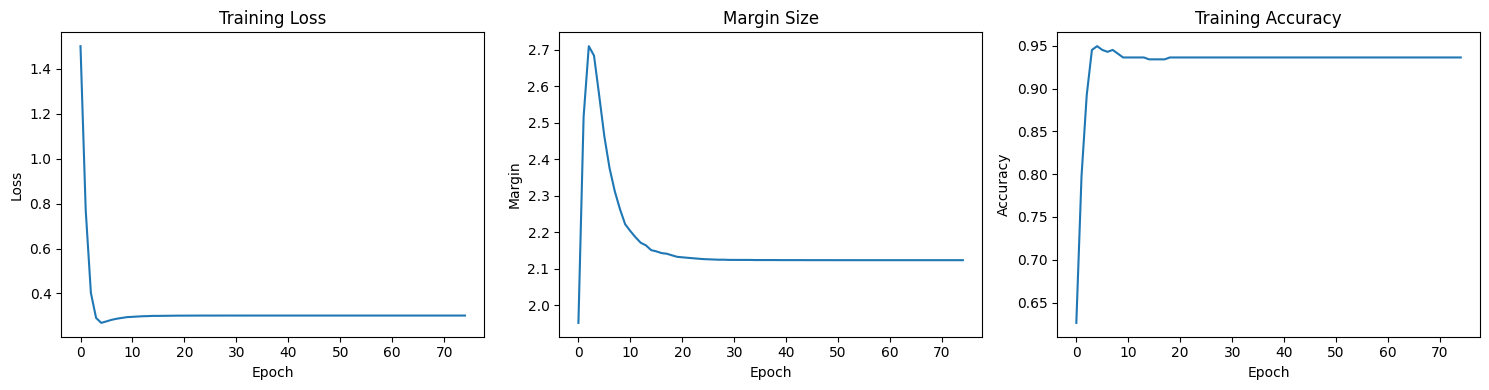

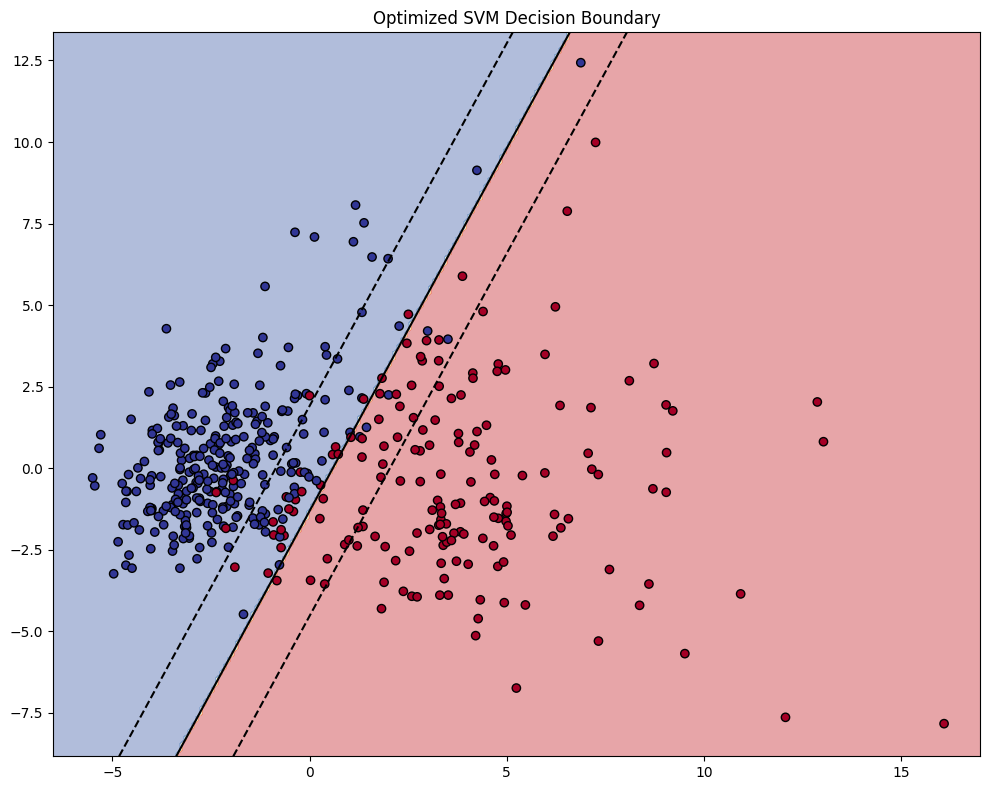


Test Accuracy: 0.956140350877193

Classification Report:
              precision    recall  f1-score   support

          -1       1.00      0.88      0.94        43
           1       0.93      1.00      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from tqdm import tqdm

class OptimizedSVM:
    def __init__(self, C=1.0, learning_rate=0.01, n_epochs=50, batch_size=32, margin_threshold=1.0):
        self.C = C
        self.lr = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.margin_threshold = margin_threshold
        self.w = None
        self.b = None

    def _initialize_weights(self, X):
        n_features = X.shape[1]
        self.w = np.random.randn(n_features) * np.sqrt(2.0 / n_features)
        self.b = 0

    def _compute_margin(self, X, y):
        decision_values = np.dot(X, self.w) + self.b
        functional_margin = y * decision_values
        return np.mean(functional_margin)

    def fit(self, X, y, verbose=True):
        self._initialize_weights(X)
        n_samples = X.shape[0]
        self.loss_history = []
        self.margin_history = []
        self.accuracy_history = []
        best_loss = float('inf')
        patience = 5
        patience_counter = 0

        for epoch in tqdm(range(self.n_epochs), desc="Training SVM"):
            epoch_loss = 0
            correct_predictions = 0

            for i in range(0, n_samples, self.batch_size):
                batch_X = X[i:i + self.batch_size]
                batch_y = y[i:i + self.batch_size]
                decision_function = np.dot(batch_X, self.w) + self.b
                margins = batch_y * decision_function
                loss = np.maximum(0, self.margin_threshold - margins)
                correct_predictions += np.sum(margins > 0)
                mask = loss > 0
                if np.any(mask):
                    dw = -np.mean(batch_X[mask] * batch_y[mask, np.newaxis], axis=0)
                    db = -np.mean(batch_y[mask])
                    self.w = (1 - self.lr * (1 / self.C)) * self.w - self.lr * dw
                    self.b -= self.lr * db
                else:
                    self.w = (1 - self.lr * (1 / self.C)) * self.w
                epoch_loss += np.mean(loss)

            avg_loss = epoch_loss / (n_samples / self.batch_size)
            accuracy = correct_predictions / n_samples
            current_margin = self._compute_margin(X, y)
            self.loss_history.append(avg_loss)
            self.margin_history.append(current_margin)
            self.accuracy_history.append(accuracy)

            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                self.lr *= 0.5
                patience_counter = 0

            if self.lr < 1e-6:
                print("Converged: Learning rate too small")
                break

            if verbose and (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{self.n_epochs}], '
                      f'Loss: {avg_loss:.4f}, '
                      f'Margin: {current_margin:.4f}, '
                      f'Accuracy: {accuracy:.4f}')

    def predict(self, X):
        decision = np.dot(X, self.w) + self.b
        return np.sign(decision)

    def plot_training_history(self):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
        ax1.plot(self.loss_history)
        ax1.set_title('Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax2.plot(self.margin_history)
        ax2.set_title('Margin Size')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Margin')
        ax3.plot(self.accuracy_history)
        ax3.set_title('Training Accuracy')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Accuracy')
        plt.tight_layout()
        plt.show()

def plot_decision_boundary(X, y, svm, title):
    plt.figure(figsize=(10, 8))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = svm.predict(grid)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black')
    w = svm.w
    b = svm.b
    plt.contour(xx, yy, (np.dot(np.array([xx.ravel(), yy.ravel()]).T, w) + b).reshape(xx.shape),
                levels=[0], colors='k', linestyles='-')
    plt.contour(xx, yy, (np.dot(np.array([xx.ravel(), yy.ravel()]).T, w) + b).reshape(xx.shape),
                levels=[-1, 1], colors='k', linestyles='--')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def main():
    data = load_breast_cancer()
    X, y = data.data, data.target
    y = np.where(y == 0, -1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    pca = PCA(n_components=2)
    X_train_2d = pca.fit_transform(X_train_scaled)
    X_test_2d = pca.transform(X_test_scaled)
    svm = OptimizedSVM(C=1.0, learning_rate=0.01, n_epochs=1000, batch_size=32, margin_threshold=1.5)
    svm.fit(X_train_2d, y_train)
    svm.plot_training_history()
    plot_decision_boundary(X_train_2d, y_train, svm, 'Optimized SVM Decision Boundary')
    y_pred = svm.predict(X_test_2d)
    print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

if __name__ == "__main__":
    main()
